# Light-sheet fluorescence microscopy

See section 2.4 in the paper for full results.

The data we use in this notebook was taken with a light-sheet fluorescence microscope.

The full resolution images require a fair bit of memory and can be a bit slow.

## Setup

Here we import some necessary packages/helper functions

In [1]:
!export CUDA_VISIBLE_DEVICES=0,1,2,3 # REPLACE this line according to your GPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3" # REPLACE this line according to your GPUs

import sys
sys.path.append("..") # since the package is one level above. Normally you should keep them on the same!
import rdmpy

# here are some basics we will need for the demo
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import block_reduce

from skimage import io
from skimage.transform import resize
from PIL import Image

# REPLACE this in according to your computer, we highly recommend using a GPU.
# We needed ~20GB of GPU memory to run at full resolution (1024 x 1024).
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')
    
    
print('Using ' +str(device) + ' for computation')

def plot_3d_projections(volume, spacing=10):
    """
    Plots the maximum intensity projections of a 3D volume along the y, x, and z axes.
    Projections are arranged with space between them, preserving aspect ratios.
    
    Parameters:
        volume (numpy.ndarray): A 3D numpy array with axes ordered as (y, x, z).
        spacing (int): Space (in pixels) between the plots.
    """
    # Compute the max projections
    z_projection = np.max(volume, axis=2)  # z-projection (center square image)
    y_projection = np.max(volume, axis=0).T  # y-projection (rectangular image below)
    x_projection = np.max(volume, axis=1)  # x-projection (rectangular image to the right)

    # Get dimensions
    z_height, z_width = z_projection.shape  # (y, x)
    y_height, y_width = y_projection.shape  # (x, z)
    x_height, x_width = x_projection.shape  # (y, z)

    # Canvas dimensions
    canvas_height = z_height + spacing + y_height  # Top (z-projection) + spacing + Bottom (y-projection)
    canvas_width = z_width + spacing + x_width  # Left (z-projection) + spacing + Right (x-projection)

    # Create a blank canvas
    canvas = np.ones((canvas_height, canvas_width))

    canvas[0:z_height, 0:z_width] = z_projection
    canvas[z_height + spacing:, :y_width] = y_projection
    canvas[:x_height, z_width + spacing:] = x_projection

    # Plot the result
    #plt.figure(figsize=(10, 10 * canvas_height / canvas_width))
    plt.imshow(canvas, cmap='gray')
    plt.axis('off')
    plt.title("Max Projections")
    plt.show()


def crop(img, c):
    return img[c:-c,c:-c,c:-c]

/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


Using cuda:1 for computation


## One-time Calibration

We calibrate with randomly scattered beads embedded in agarose. Notice how the beads extend in z extent as they move away from the center (along the y-axis).

In [2]:
# We set the PSF dim to 48 to ensure enough buffer to cover the full PSF.
psf_dim = 48

<tifffile.TiffFile '1_CH01_000000.tif'> OME series failed to read '1_CH00_000000.tif'. Missing data are zeroed


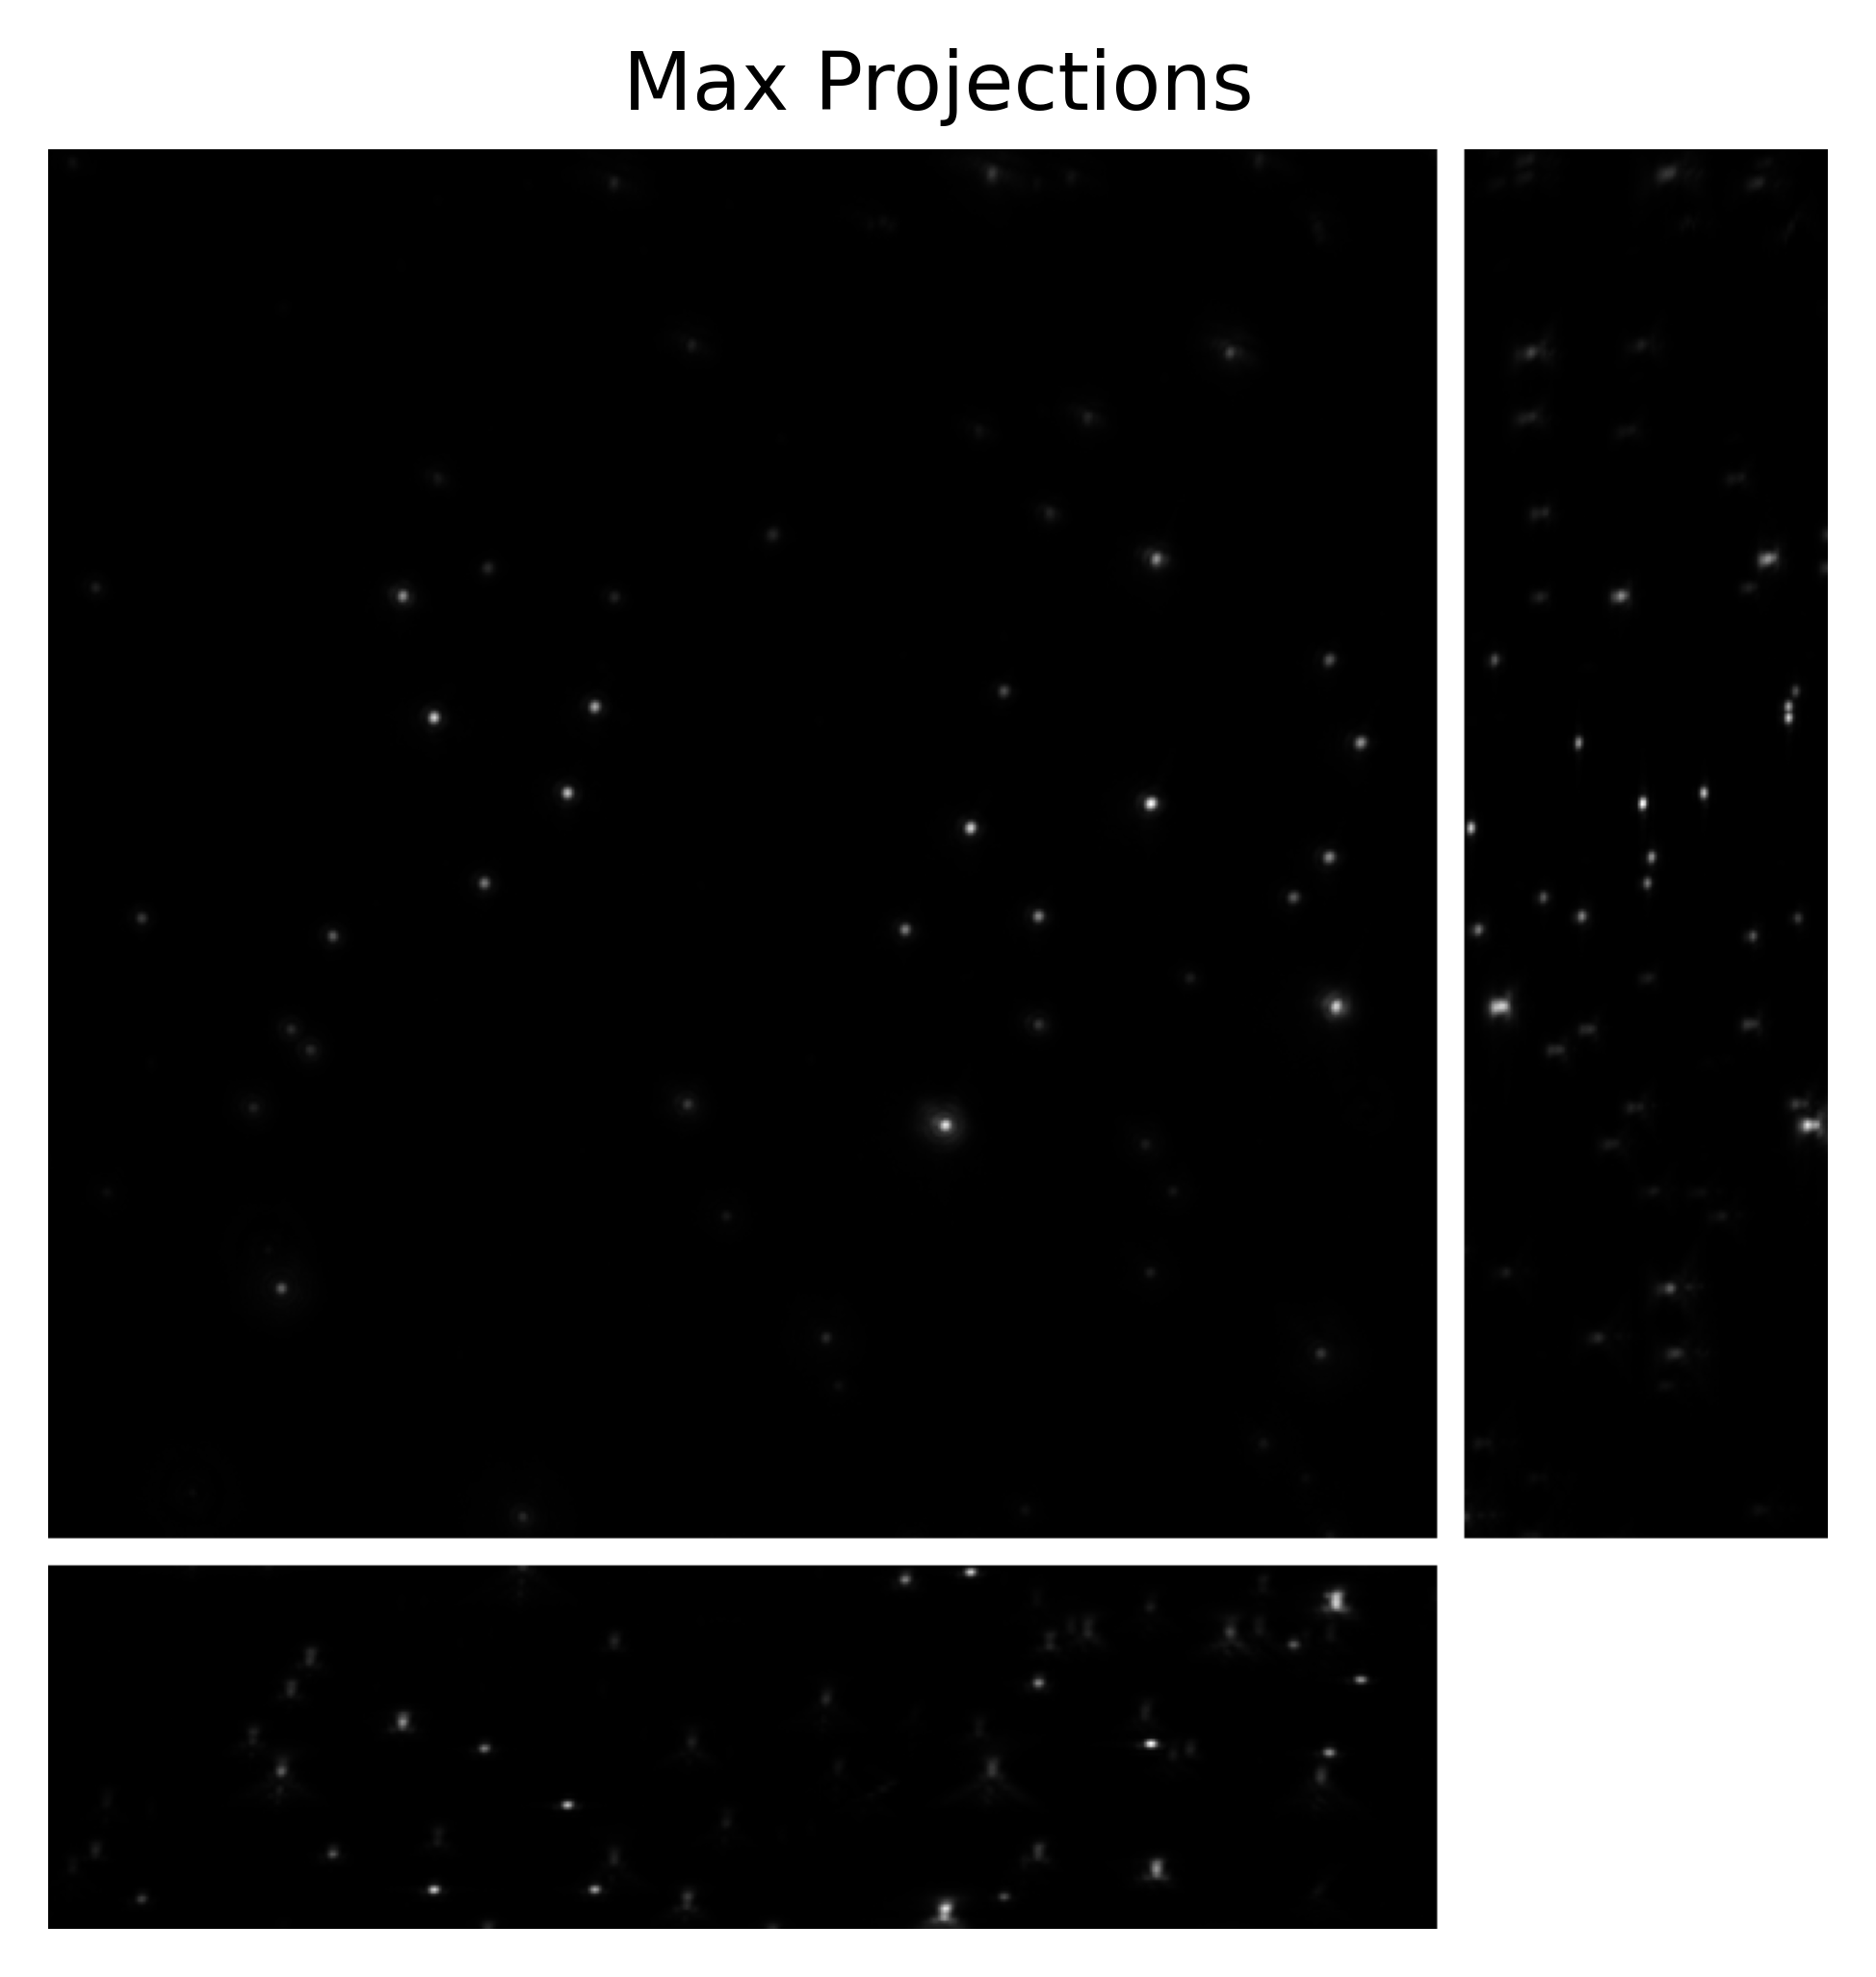

In [3]:
calib_stack = imread("rdm_data/light-sheet/beads/1_CH01_000000.tif")
calib_stack = calib_stack / calib_stack.max()
calib_stack = calib_stack[1, :, :, :].transpose(1, 2, 0)

plot_3d_projections(calib_stack)

Now we calibrate using this stack. For now we will use interpolation model.

In [4]:
psf_cube, psf_locs = rdmpy.calibrate_sdm(
    calib_stack,
    psf_dim,
    model="interpolation",
    device=device,
)

min_idx: tensor(8, device='cuda:1')


## Sheet Convolution. 
With some PSFs in hand we can try out sheet convolution at the locations from the calibration image to see how we did!

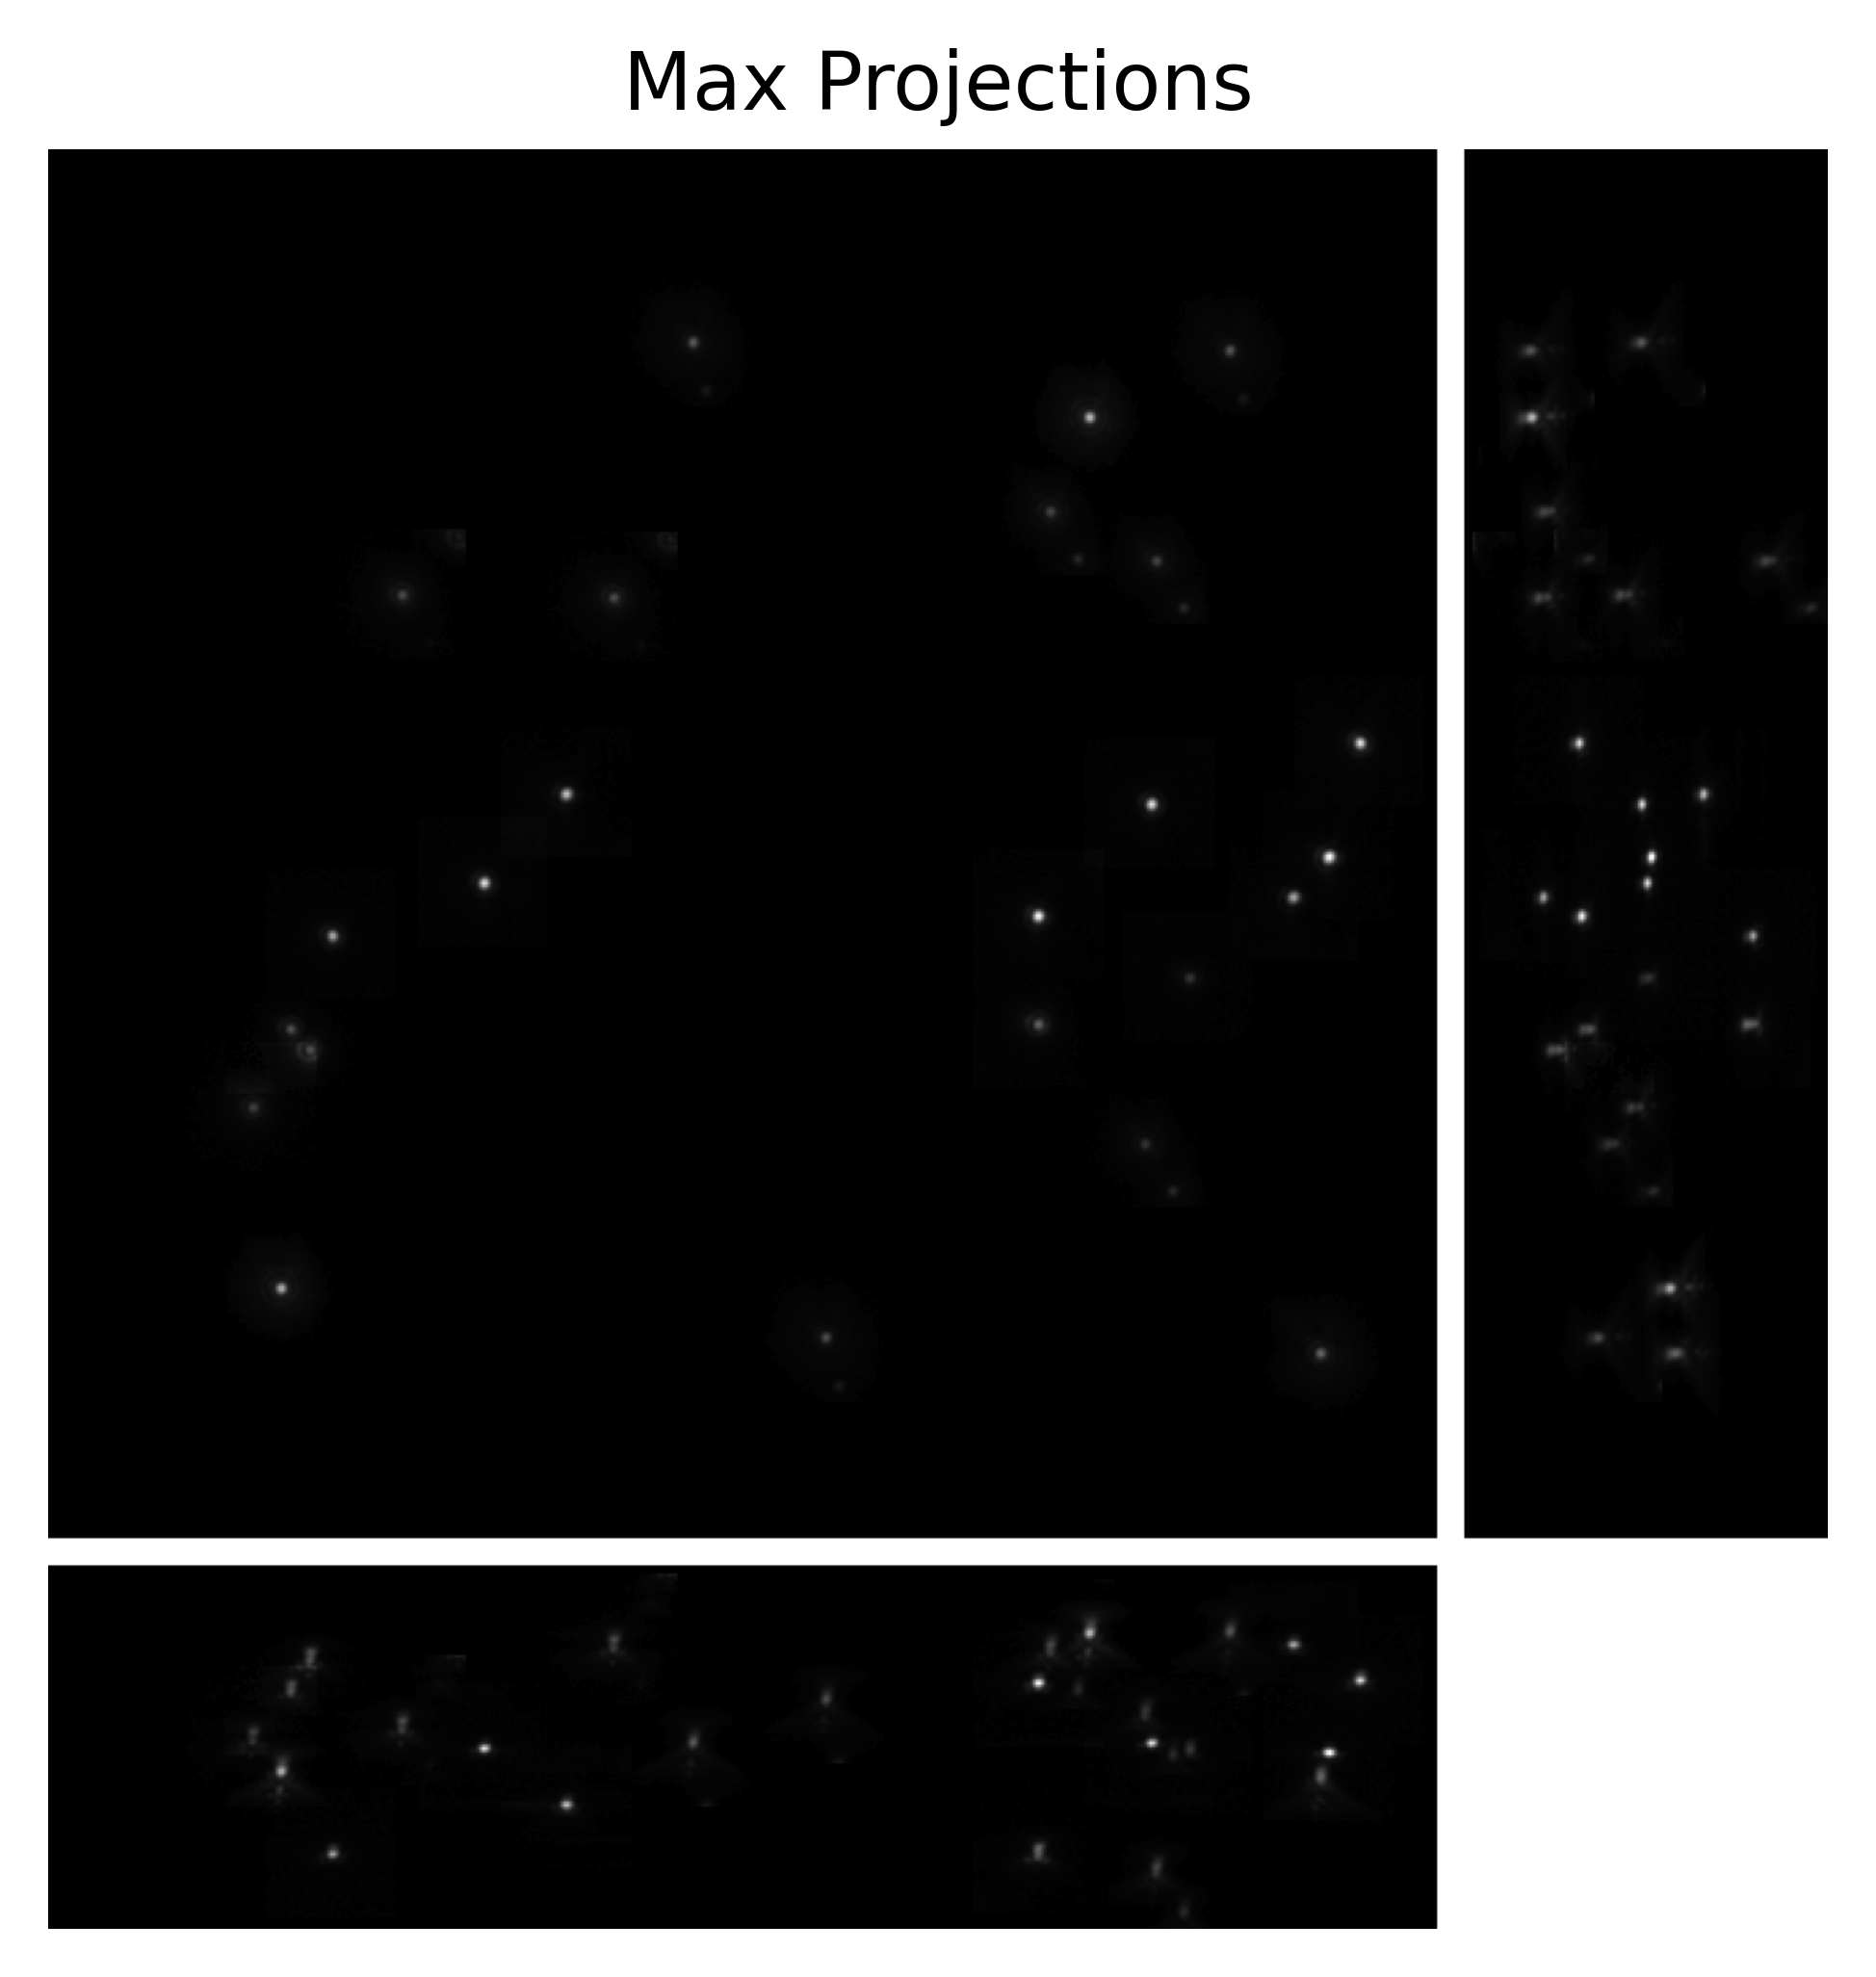

In [5]:
# get a stack of ones as the calibration PSF locations.
test = torch.zeros_like(torch.tensor(calib_stack, device=device)).float()
for loc in psf_locs:
    test[loc[0], loc[1], loc[2]] = 1

# sheet convolve them with our calibrated PSFs to get an estimate of the calibration image.
calib_stack_est = rdmpy.sheet_convolve(test, psf_cube, device=device)
plot_3d_projections((calib_stack_est/calib_stack_est.max()).cpu().numpy())


# Sheet Deconvolution
Now we can see what happpens if we sheet deconvolve the calibration image. Ideally, we'd see a uniform set of beads throughout the FoV!

In [6]:
bead_est = rdmpy.sheet_deconvolve(torch.tensor(calib_stack, device=device).float(), psf_cube, iters=50, lr=1e-2, device=device)

100%|██████████| 50/50 [10:32<00:00, 12.66s/it]


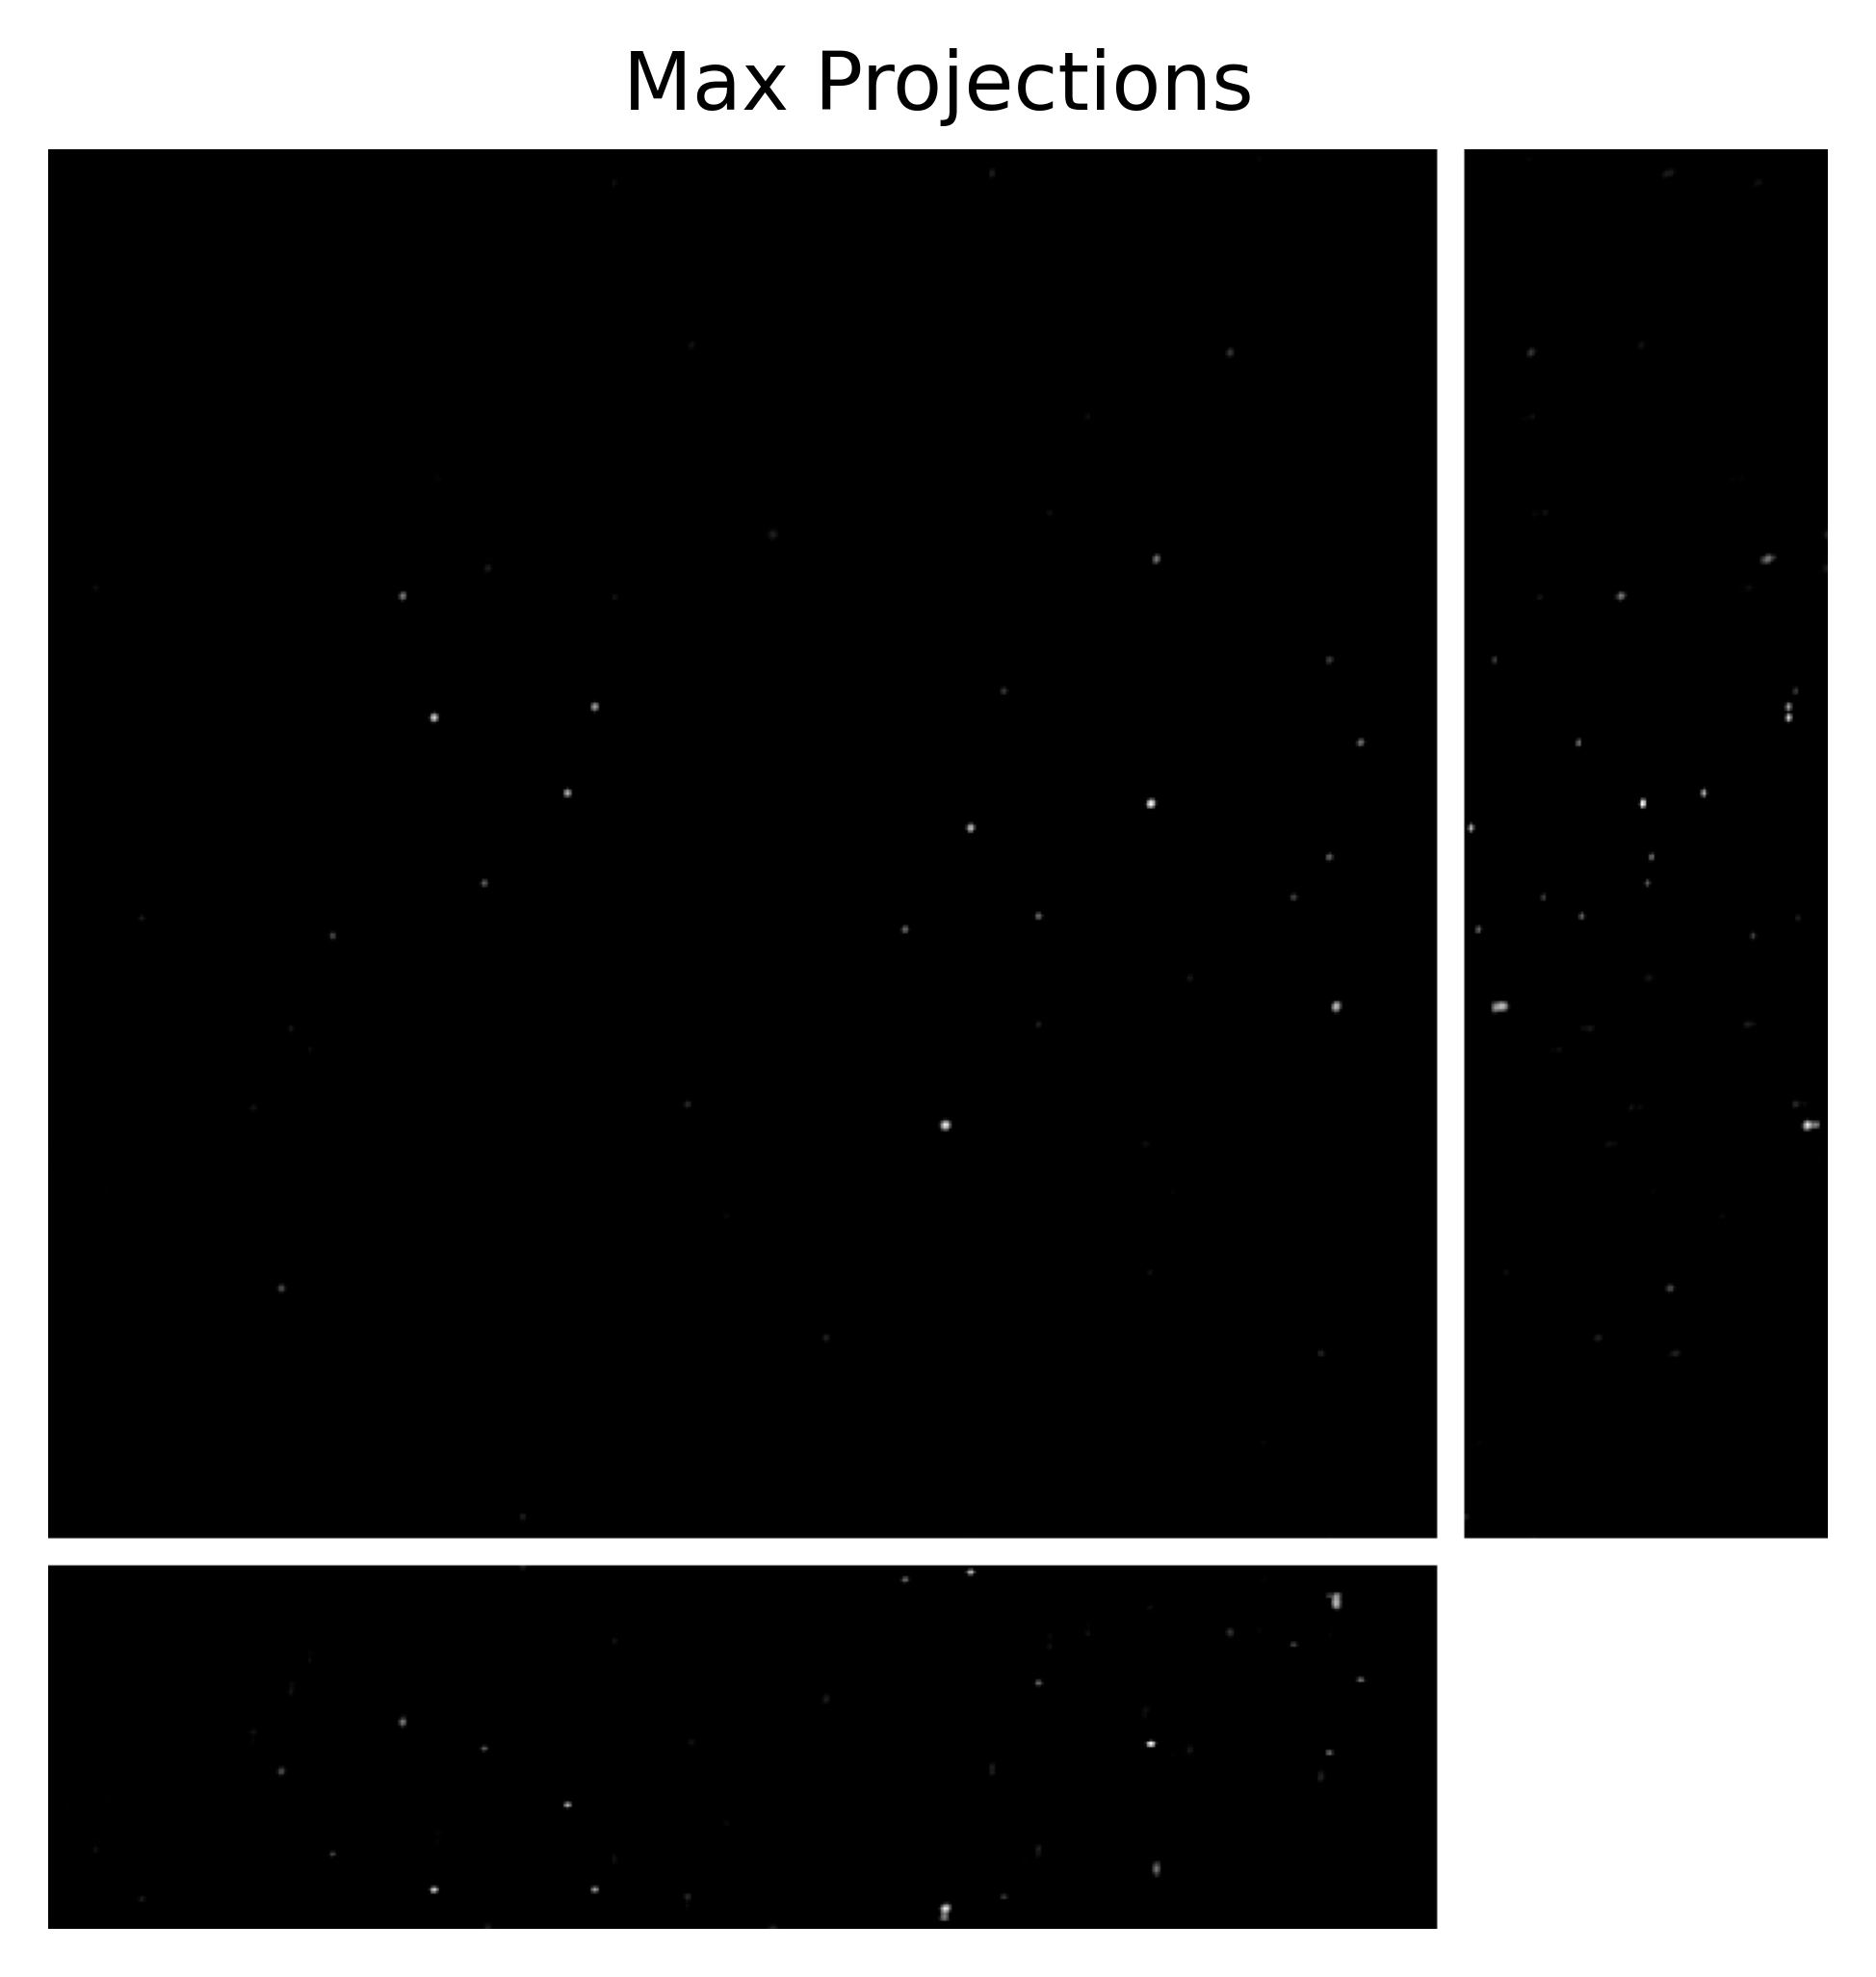

In [7]:
plot_3d_projections(bead_est/bead_est.max())

## Restarget composite
Now we can repeat the process for a cell sample. This time we will use the Gibson-Lanni PSF model to help with the noise.


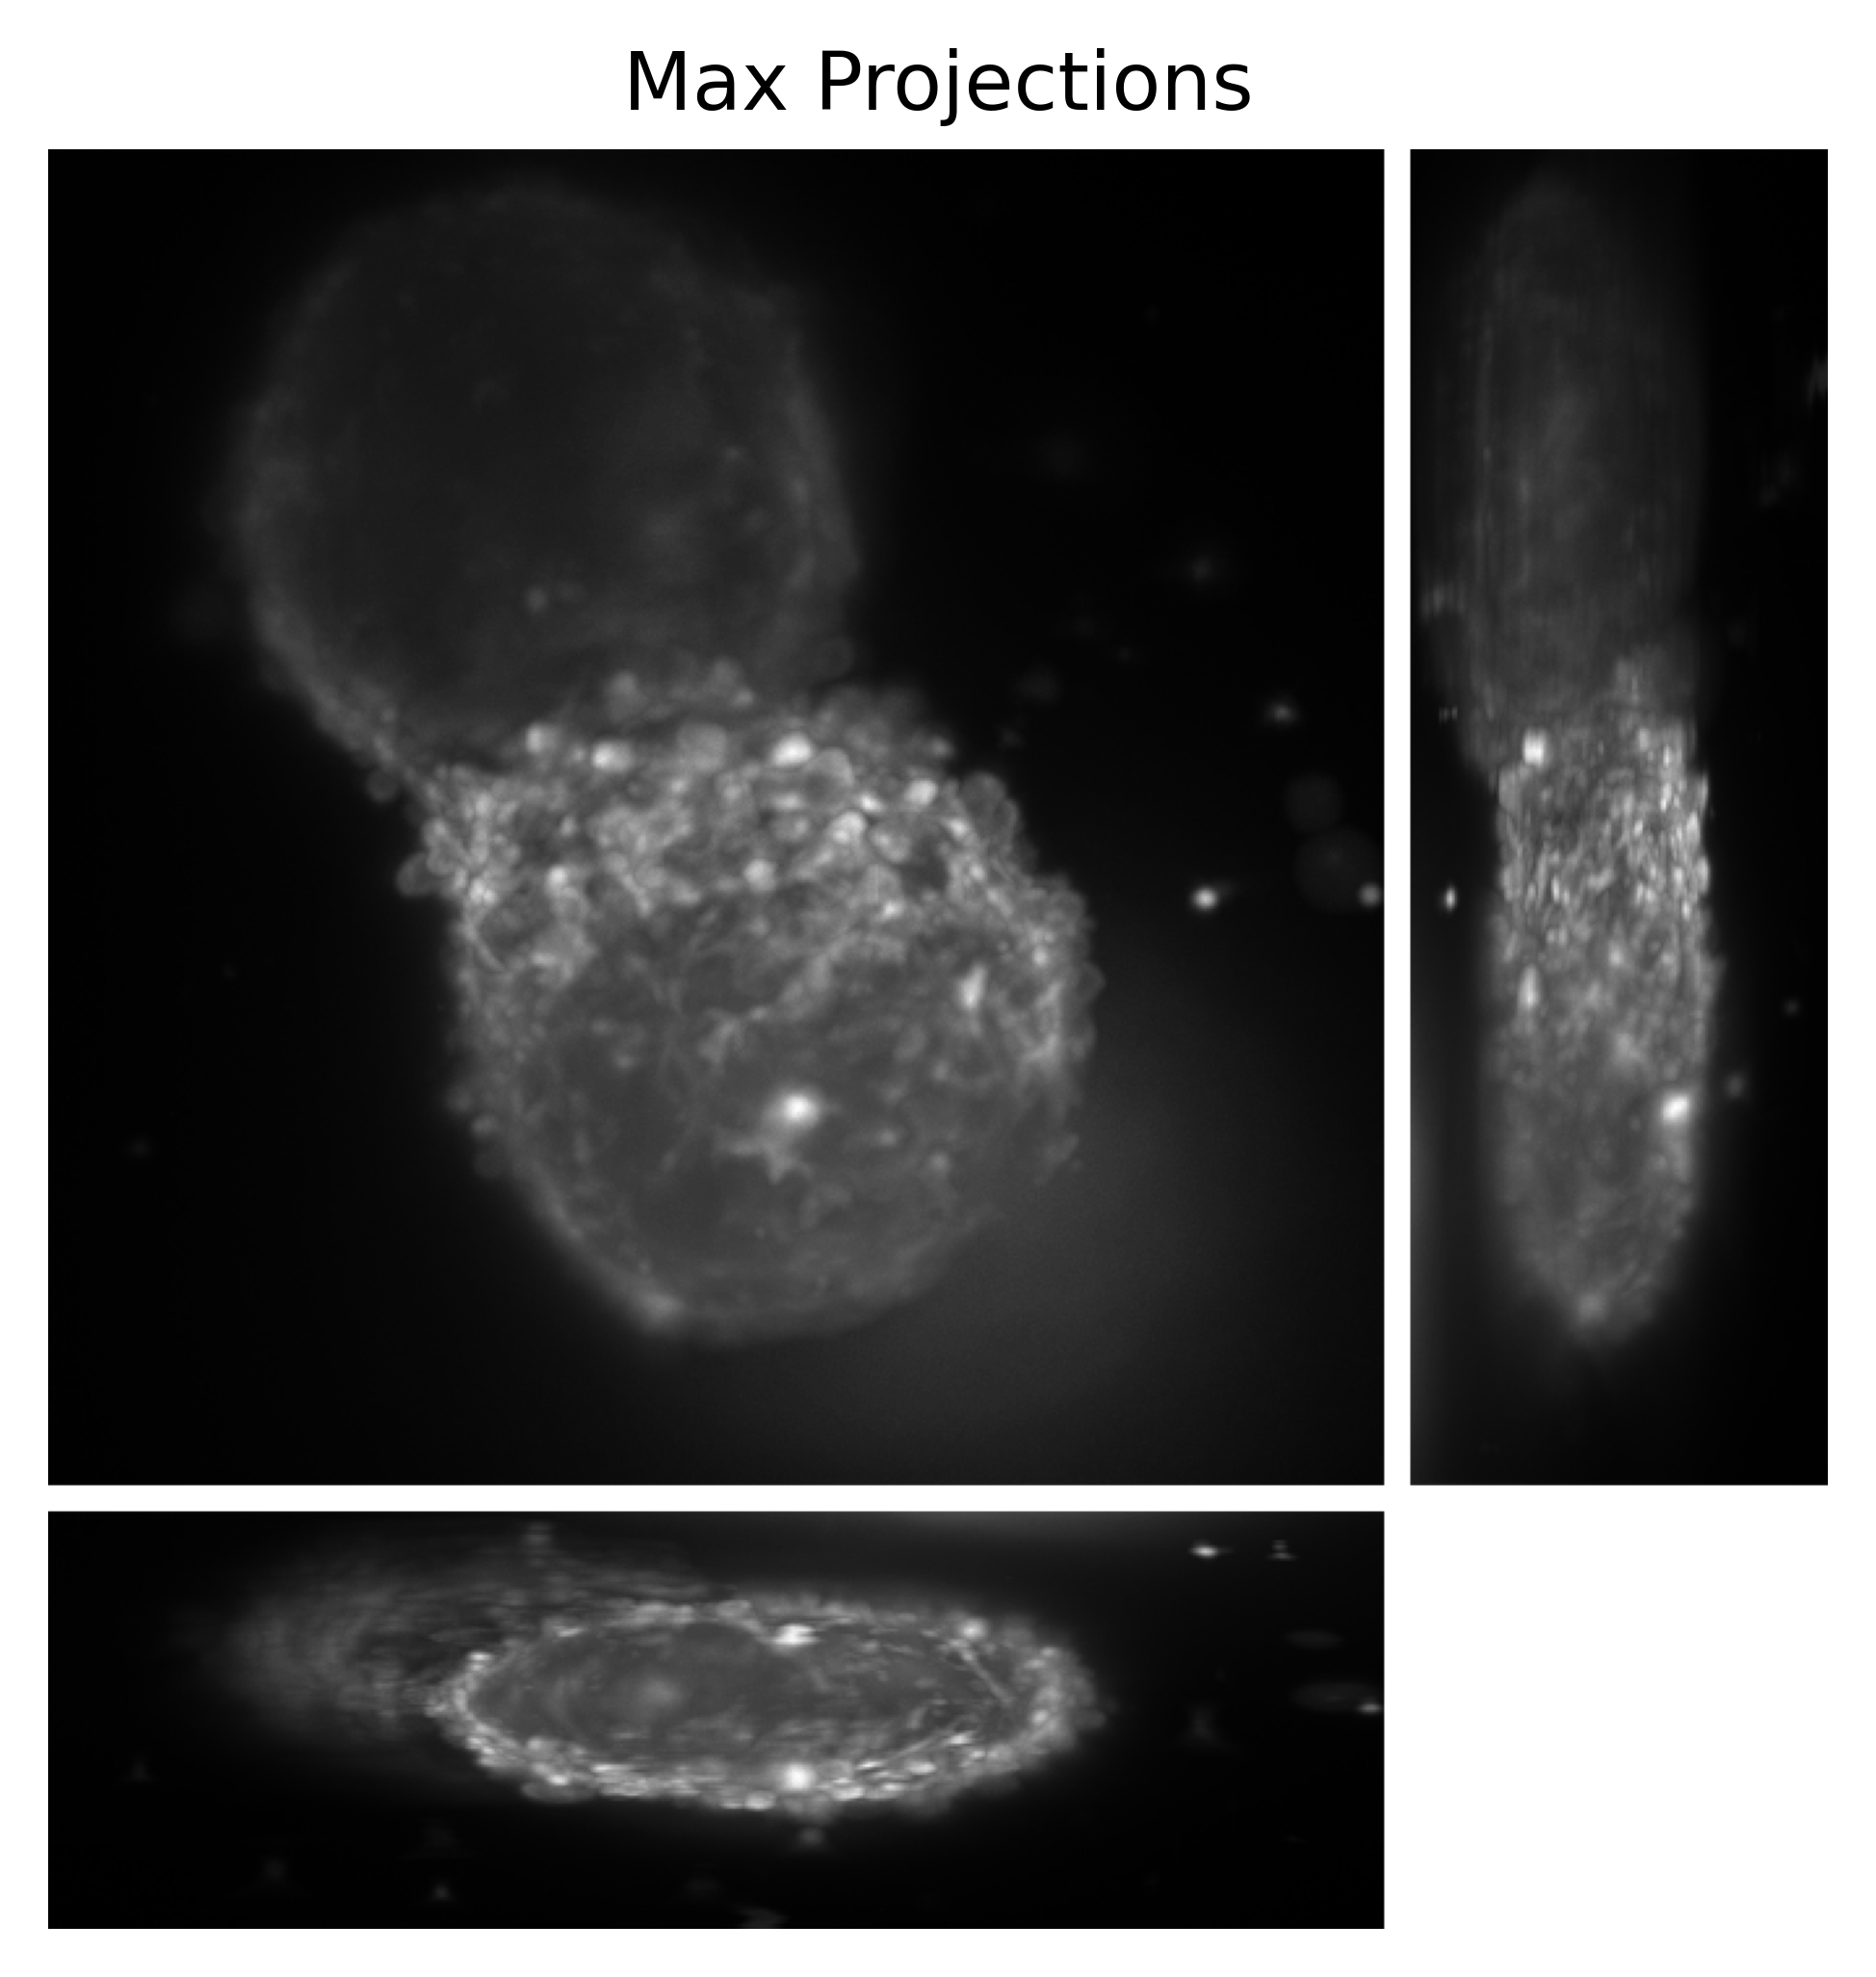

In [8]:
obj = imread("rdm_data/light-sheet/cells/1_CH00_000000.tif")
obj = obj.transpose(1, 2, 0)
obj = block_reduce(obj, (1, 1, 3))
obj = obj[:, :, :-1]
obj = obj - obj.min()
obj = obj / obj.max()
plot_3d_projections(obj)

In [9]:
# Calibration
coeffs, waist, spread, defocus_rate, psf_locs, gl_params, dx, dz = rdmpy.calibrate_sdm(
    calib_stack,
    psf_dim,
    model="gl",
    device=device,
)

min_idx: tensor(8, device='cuda:1')


  0%|          | 0/100 [00:00<?, ?it/s]/home/amit/micromamba/envs/psf/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 100/100 [02:54<00:00,  1.74s/it]

waist:  0.00015225537936203182
spread:  0.01590679958462715
defocus_rate:  0.20000000298023224
coeff:  0.6800000071525574
M :  100.00004577636719
NA :  1.2031383514404297
ng0 :  1.5005818605422974
ng :  1.4994255304336548
ni0 :  1.5005818605422974
ni :  1.4994049072265625
ti0 :  149.99871826171875
tg :  170.00079345703125
tg0 :  169.99920654296875
zd0 :  200000.0
depth :  -0.5
dx:  0.03982004150748253
dz:  0.15464389324188232


In [10]:
# now get the psfs
psf_dim = 48
zmax = 48  # calib_stack.shape[2]
num_psfs = calib_stack.shape[0] // 2

psf_cube, _ = rdmpy.get_ls_psfs(
    0.7,
    waist,
    spread,
    defocus_rate,
    dx,
    dz,
    psf_dim,
    zmax,
    num_psfs,
    wavelength=550e-6,
    NA=0.2,
    get_center_vals=True,
    gl_params=gl_params,
    device=device,
)

100%|██████████| 256/256 [00:01<00:00, 160.59it/s]


In [11]:
# finally let's run sheet deconvolution on the sample
obj_est = rdmpy.sheet_deconvolve(torch.tensor(obj, device=device).float(), psf_cube, iters=50, lr=5e-2,
    l2_reg=3e-7,
    l1_reg=0,
    tv_reg=1e-11,
    method="autograd",
    opt_params={"upper_projection": False, "init": "zero"}, device=device)

100%|██████████| 50/50 [10:45<00:00, 12.91s/it]


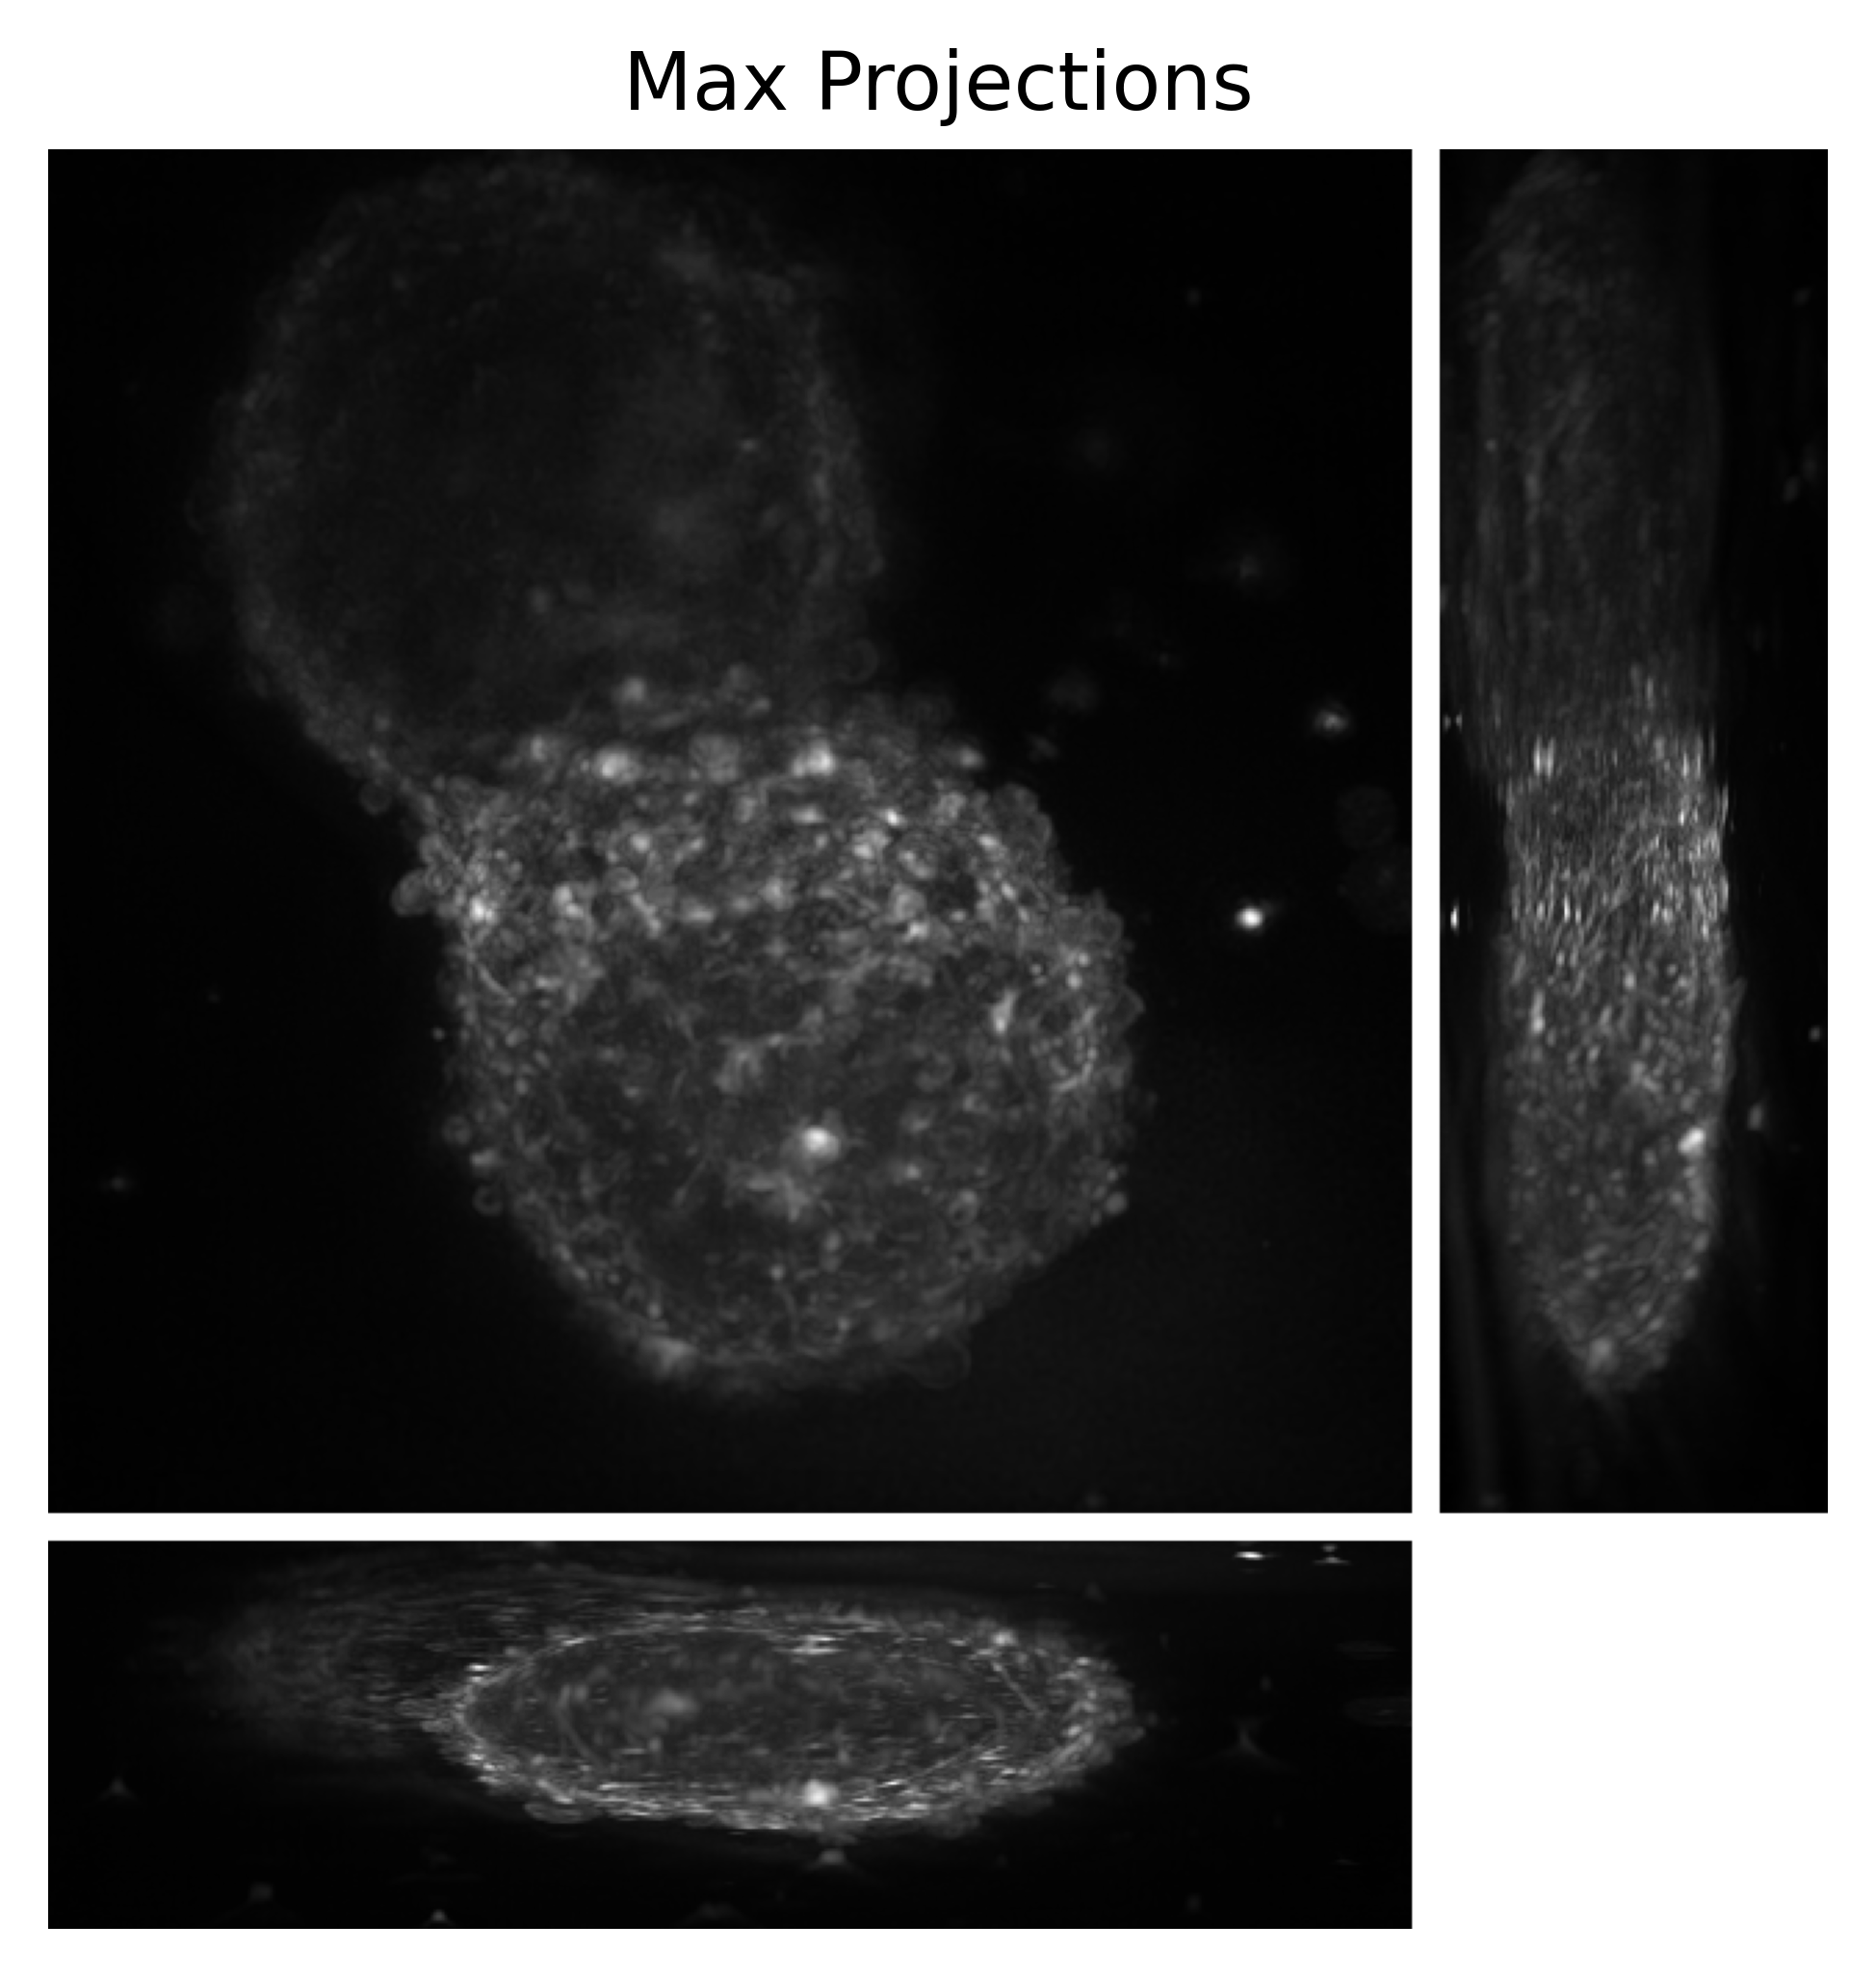

In [12]:
# and plot!
crop=10
plot_3d_projections((obj_est[crop:-crop,crop:-crop,crop:-crop]))